# Knowledge Graph Agent with LlamaParse

<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/knowledge_graphs/kg_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we build a knowledge graph agent over the SF 2023 Budget Proposal. We use LlamaIndex abstractions to construct a knowledge graph, and we store the property graph in neo4j. We then build an agent that can interact with the knowledge graph as a tool.

## Setup (Installs, Data, Models)

In [2]:
# !pip install llama-index
# !pip install llama-index-core==0.10.42
# !pip install llama-index-embeddings-openai
# !pip install llama-index-postprocessor-flag-embedding-reranker
# !pip install git+https://github.com/FlagOpen/FlagEmbedding.git
# !pip install llama-index-graph-stores-neo4j
# !pip install llama-parse

In [13]:
import nest_asyncio

nest_asyncio.apply()

In [14]:
import os
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()


openai_api_key = os.getenv("OPENAI_API_KEY")
llama_api_key = os.getenv("LLAMA_CLOUD_API_KEY")
# API access to llama-cloud
# os.environ["LLAMA_CLOUD_API_KEY"] = "llx-"

#### Setup Model

Here we use gpt-4o and default OpenAI embeddings.

In [15]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

llm = OpenAI(model="gpt-4o", api_key=openai_api_key)
embed_model = OpenAIEmbedding(model="text-embedding-3-small")

Settings.llm = llm
Settings.embed_model = embed_model

#### Load Data

Here we load the 2023 Budget PDF and parse it with LlamaParse.

In [4]:
file_path = './data/1722336031_VNM_-_Thuyết_trình_KQKD_Q2.2024_.pdf'

from llama_index.readers.file import PyMuPDFReader

loader = PyMuPDFReader()
documents = loader.load(file_path=file_path)

In [5]:
from llama_index.core.node_parser import SentenceSplitter

text_parser = SentenceSplitter(
    chunk_size=1024,
    # separator=" ",
)

text_chunks = []
# maintain relationship with source doc index, to help inject doc metadata in (3)
doc_idxs = []
for doc_idx, doc in enumerate(documents):
    cur_text_chunks = text_parser.split_text(doc.text)
    text_chunks.extend(cur_text_chunks)
    doc_idxs.extend([doc_idx] * len(cur_text_chunks))

In [10]:
print(text_chunks[:3])

['THUYẾT TRÌNH LỢI NHUẬN\nGiai đoạn 6 tháng kết thúc ngày 30/06/2024 (“năm 2024”)', 'Giai đoạn 6T kết thúc ngày 30/06/2024\nTóm Tắt Kết Quả Kinh Doanh \n3\nKết quả hợp nhất – Q2/2024\nĐơn vị: Tỷ đồng\n16.665\n9,5% YoY\nTỔNG DOANH THU\n7.068\n+14,9% YoY\nLỢI NHUẬN GỘP\n42,4%\n+200 đcb YoY\nBIÊN LÃI GỘP\n 2.695\n+20,9% YoY\nLỢI NHUẬN RÒNG\n16,2%\n+151 đcb YoY\nBIÊN LÃI RÒNG\n 934\n+21,7% YoY\nEPS (VNĐ)\n48,7%\n52,3%\nKH2024\nKH2024\n 30.790\n+5,6% YoY\nTỔNG DOANH THU\n 4.903\n+18,6% YoY\nLN SAU THUẾ\n6T/2024', 'Giai đoạn 6T kết thúc ngày 30/06/2024\n4\nThông Điệp Tổng Giám Đốc\nNhững con số này là minh chứng cho những nỗ lực không ngừng trong \ncải tiến sản phẩm, nâng cao chất lượng dịch vụ, mở rộng thị trường và tối ưu \nhiệu quả hoạt động. Dù còn nhiều điều cần làm, nhưng với kết quả đáng khích \nlệ trong nửa đầu năm 2024, chúng tôi tự tin hướng đến mục tiệu hoàn thành \nkế hoạch cả năm và tin tưởng rằng Vinamilk sẽ tiếp tục là điểm sáng trên thị \ntrường, mang lại giá trị bền vững cho

In [42]:
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore

# Note: used to be `Neo4jPGStore`
graph_store = Neo4jPropertyGraphStore(
    username="neo4j",
    password="ttt@123ASD",
    url="bolt://localhost:7687",
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [50]:
graph_store.clear()

AttributeError: 'Neo4jPropertyGraphStore' object has no attribute 'clear'

In [43]:
from llama_index.core import PropertyGraphIndex
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor


index = PropertyGraphIndex.from_documents(
    documents,
    embed_model=OpenAIEmbedding(model_name="text-embedding-3-small"),
    kg_extractors=[
        SchemaLLMPathExtractor(
            llm=OpenAI(model="gpt-4o-mini", temperature=0.3)
        )
    ],
    property_graph_store=graph_store,
    show_progress=True,
)


Parsing nodes:   0%|          | 0/22 [00:00<?, ?it/s]

Extracting paths from text with schema:  17%|█▋        | 4/23 [00:08<00:26,  1.40s/it]/Users/ngocp/Documents/projects/finance-bot/.venv/lib/python3.10/site-packages/pydantic/json_schema.py:1503: RuntimeWarning: coroutine 'arun_transformations' was never awaited
  named_required_fields: list[tuple[str, bool, CoreSchemaField]] = [
Generating embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it]
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (e, row) { ... }} {position: line: 10, column: 21, offset: 397} for query: "\n                    UNWIND $data AS row\n                    MERGE (e:__Node__ {id: row.id})\n                    SET e += apoc.map.clean(row.properties, [], [])\n                    SET e.name = row.name, e

In [38]:
!pip install py2neo matplotlib

  Using cached matplotlib-3.9.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.3 kB)
Using cached matplotlib-3.9.2-cp310-cp310-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp310-cp310-macosx_11_0_arm64.whl (249 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.54.1-cp310-cp310-macosx_11_0_arm64.whl (2.3 MB)
Using cached kiwisolver-1.4.7-cp310-cp310-macosx_11_0_arm64.whl (64 kB)


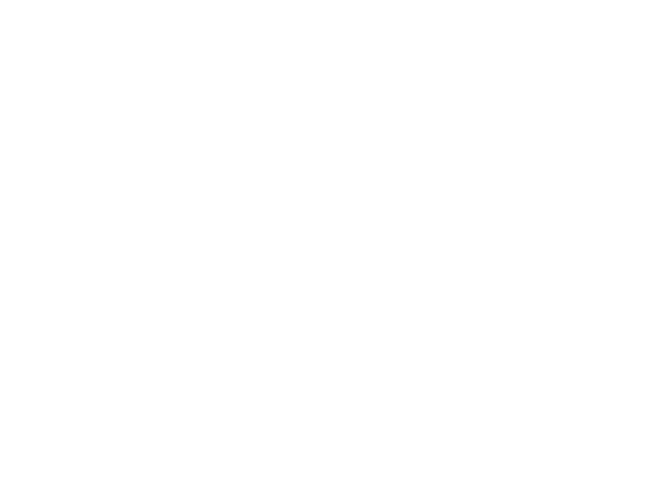

In [1]:
from py2neo import Graph
import networkx as nx


import matplotlib.pyplot as plt

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "ttt@123ASD"))

# Query to get nodes and relationships
query = """
MATCH (n)-[r]->(m)
RETURN n, r, m
"""
data = graph.run(query).data()

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for record in data:
    n = record['n']
    m = record['m']
    r = record['r']
    
    if n['name'] is not None and m['name'] is not None:
        print('check:', n['name'], m['name'], r.type)
        
        G.add_node(n['name'][:30], label=n['name'][:30])
        G.add_node(m['name'][:30], label=m['name'][:30])
        G.add_edge(n.identity, m.identity, label=r.type)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [33]:
# question = "Nền kinh tế Việt Nam trong quý 2/2024 tăng trưởng bao nhiêu % so với cùng kỳ năm trước?"
# question = "Bức tranh nền kinh tế Việt Nam trong quý 2/2024 như thế nào?"
question = "Doanh thu các thị trường nước ngoài"

In [34]:
retriever = index.as_retriever(
    include_text=False,  # include source text in returned nodes, default True
)

nodes = retriever.retrieve(question)

for node in nodes:
    print(node.text)

Doanh thu thuần xuất khẩu -> USED_FOR -> thị trường xuất khẩu trọng điểm


In [30]:
query_engine = index.as_query_engine(include_text=True)
response = query_engine.query(question)

print(str(response))

Trong quý 2/2024, nền kinh tế Việt Nam có những điểm sáng đáng chú ý. Doanh thu thuần từ xuất khẩu đạt 1.740 tỷ đồng, tăng 37,0% so với cùng kỳ năm trước, cho thấy sự cải thiện đáng kể so với mức tăng 5,9% trong quý 1/2024. Điều này phản ánh sự cải tiến sản phẩm và tăng cường hỗ trợ các đối tác tại các thị trường xuất khẩu trọng điểm. Ngoài ra, doanh thu thuần từ các chi nhánh nước ngoài cũng đạt 1.384 tỷ đồng, tăng trưởng 21,8% so với cùng kỳ, vượt qua mức tăng 9,6% trong quý 1/2024. Các công ty như Angkormilk và Driftwood đã có những nỗ lực đáng kể trong marketing và đảm bảo nguồn cung để hoàn thành đơn hàng, góp phần vào sự tăng trưởng này.
